In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

import composition as comp

%matplotlib inline

In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print(feature_list)
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:73: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))


['reco_log_energy', 'InIce_log_charge_1_6', 'reco_cos_zenith', 'lap_chi2', 'NChannels_1_6', 'log_s125']
number training events = 36127


Get error in charge vs. energy distribution

In [5]:
pipeline = comp.get_pipeline('GBC')
param_range = np.arange(1, 15)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=2,
                  n_jobs=10)
gs = gs.fit(X_train, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
pipeline.set_params(**gs.best_params_)
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=1 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] classifier__max_depth=2 .........................................
[CV] ................................ classifier__max_depth=1 -   0.0s
[CV] classifier__max_depth=3 .........................................
[CV] ................................ classifier__max_depth=1 -   0.0s
[CV] classifier_

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.4s


[CV] ................................ classifier__max_depth=5 -   0.0s
[CV] classifier__max_depth=7 .........................................
[CV] ................................ classifier__max_depth=5 -   0.0s
[CV] classifier__max_depth=7 .........................................
[CV] ................................ classifier__max_depth=5 -   0.0s
[CV] classifier__max_depth=7 .........................................
[CV] ................................ classifier__max_depth=6 -   0.0s
[CV] classifier__max_depth=8 .........................................
[CV] ................................ classifier__max_depth=6 -   0.0s
[CV] classifier__max_depth=8 .........................................
[CV] ................................ classifier__max_depth=6 -   0.0s
[CV] classifier__max_depth=8 .........................................
[CV] ................................ classifier__max_depth=6 -   0.0s
[CV] classifier__max_depth=8 .........................................
[CV] .

[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:  2.4min finished


best GS CV score = 0.831843219753
best GS CV depths = {'classifier__max_depth': 7}
Grid scores on development set:
0.777 (+/-0.007) for {'classifier__max_depth': 1}
0.808 (+/-0.009) for {'classifier__max_depth': 2}
0.819 (+/-0.009) for {'classifier__max_depth': 3}
0.824 (+/-0.007) for {'classifier__max_depth': 4}
0.829 (+/-0.008) for {'classifier__max_depth': 5}
0.830 (+/-0.009) for {'classifier__max_depth': 6}
0.832 (+/-0.007) for {'classifier__max_depth': 7}
0.831 (+/-0.008) for {'classifier__max_depth': 8}
0.831 (+/-0.009) for {'classifier__max_depth': 9}
0.831 (+/-0.006) for {'classifier__max_depth': 10}
0.829 (+/-0.009) for {'classifier__max_depth': 11}
0.828 (+/-0.006) for {'classifier__max_depth': 12}
0.828 (+/-0.008) for {'classifier__max_depth': 13}
0.824 (+/-0.009) for {'classifier__max_depth': 14}


In [6]:
clf_name = clf.__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=10)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

GradientBoostingClassifier
Test accuracy: 82.7682%
Train accuracy: 87.9176%
CV score: 82.03% (+/- 1.26%)


In [7]:
correctly_identified_mask = (test_predictions == y_test)

energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
# energy_bins = np.arange(6.2, 9.51, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

MC_proton_mask = (le.inverse_transform(y_test) == 'P')
MC_iron_mask = (le.inverse_transform(y_test) == 'Fe')
# Get number of MC proton and iron as a function of MC energy
num_MC_protons_energy = np.histogram(log_energy[MC_proton_mask],
                                     bins=energy_bins)[0]
num_MC_protons_energy_err = np.sqrt(num_MC_protons_energy)
num_MC_irons_energy = np.histogram(log_energy[MC_iron_mask],
                                   bins=energy_bins)[0]
num_MC_irons_energy_err = np.sqrt(num_MC_irons_energy)
num_MC_total_energy = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_total_energy_err = np.sqrt(num_MC_total_energy)

# Get number of reco proton and iron as a function of MC energy
num_reco_proton_energy = np.histogram(
    log_energy[MC_proton_mask & correctly_identified_mask],
    bins=energy_bins)[0]
num_reco_proton_energy_err = np.sqrt(num_reco_proton_energy)
num_reco_iron_energy = np.histogram(
    log_energy[MC_iron_mask & correctly_identified_mask],
    bins=energy_bins)[0]
num_reco_iron_energy_err = np.sqrt(num_reco_iron_energy)
num_reco_total_energy = np.histogram(
    log_energy[correctly_identified_mask],
    bins=energy_bins)[0]
num_reco_total_energy_err = np.sqrt(num_reco_total_energy)

# Calculate reco proton and iron fractions as a function of MC energy
reco_proton_frac, reco_proton_frac_err = comp.ratio_error(
    num_reco_proton_energy, num_reco_proton_energy_err,
    num_MC_protons_energy, num_MC_protons_energy_err)

reco_iron_frac, reco_iron_frac_err = comp.ratio_error(
    num_reco_iron_energy, num_reco_iron_energy_err,
    num_MC_irons_energy, num_MC_irons_energy_err)

reco_total_frac, reco_total_frac_err = comp.ratio_error(
    num_reco_total_energy, num_reco_total_energy_err,
    num_MC_total_energy, num_MC_total_energy_err)

textstr = 
Training features: 
1) $\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$
2) InIce charge (top 10\%)
3) $\cos(\theta_{\mathrm{reco}})$
4) $\chi^2_{\mathrm{Lap}}/\mathrm{n.d.f}$
5) NChannels (top 10\%)
6) $\log_{10}(S_{\mathrm{125}})$


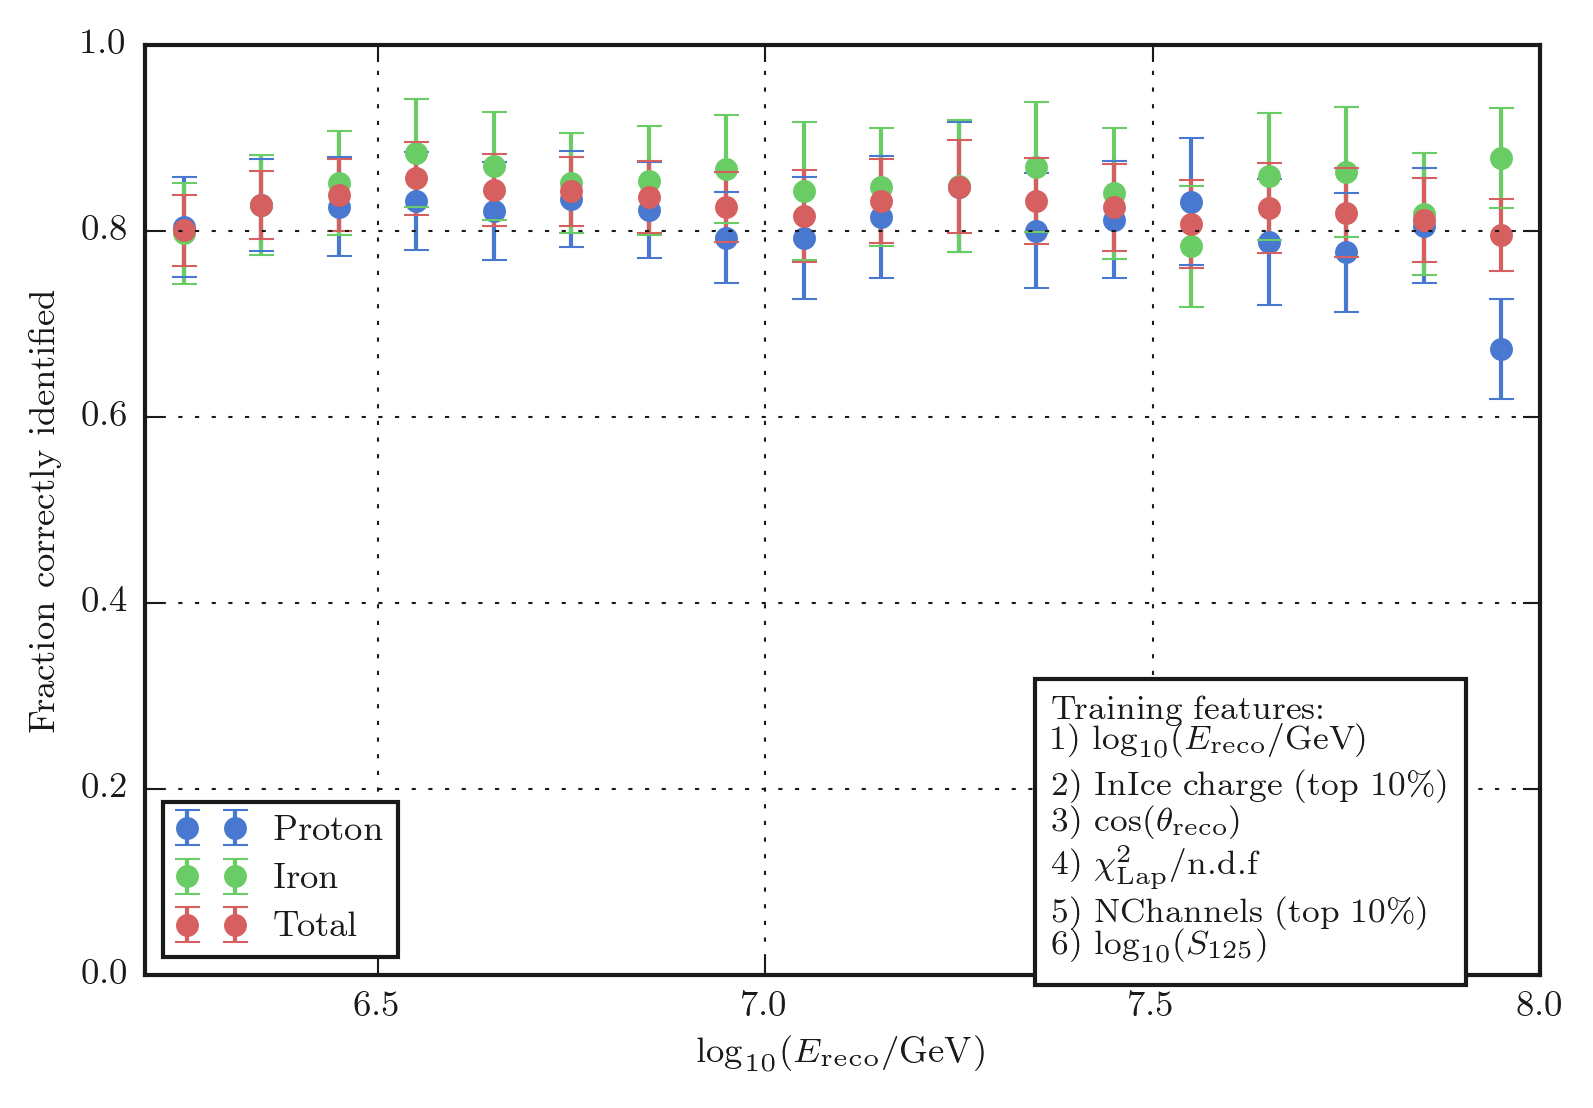

[ 0.80060729  0.82749562  0.83815029  0.85632184  0.84390244  0.84247788
  0.83639884  0.82572227  0.815486    0.83196721  0.84737679  0.83215797
  0.825       0.80699088  0.8248062   0.81954887  0.81129477  0.79562044]


In [8]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
ax.errorbar(energy_midpoints, reco_proton_frac,
            yerr=reco_proton_frac_err,
            # xerr=energy_bin_width / 2,
            marker='.', markersize=10,
            label='Proton')
ax.errorbar(energy_midpoints, reco_iron_frac,
            yerr=reco_iron_frac_err,
            # xerr=energy_bin_width / 2,
            marker='.', markersize=10,
            label='Iron')
ax.errorbar(energy_midpoints, reco_total_frac,
            yerr=reco_total_frac_err,
            # xerr=energy_bin_width / 2,
            marker='.', markersize=10,
            label='Total')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
plt.legend(loc=3)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print('textstr = \n' + textstr)
props = dict(facecolor='white')
ax.text(0.65, 0.3, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_GB.png'
plt.savefig(outfile)
plt.show()
print(reco_total_frac)

1) 0.23581193386
2) 0.225024186792
3) 0.151579672249
4) 0.142687217818
5) 0.142515711529
6) 0.102381277753


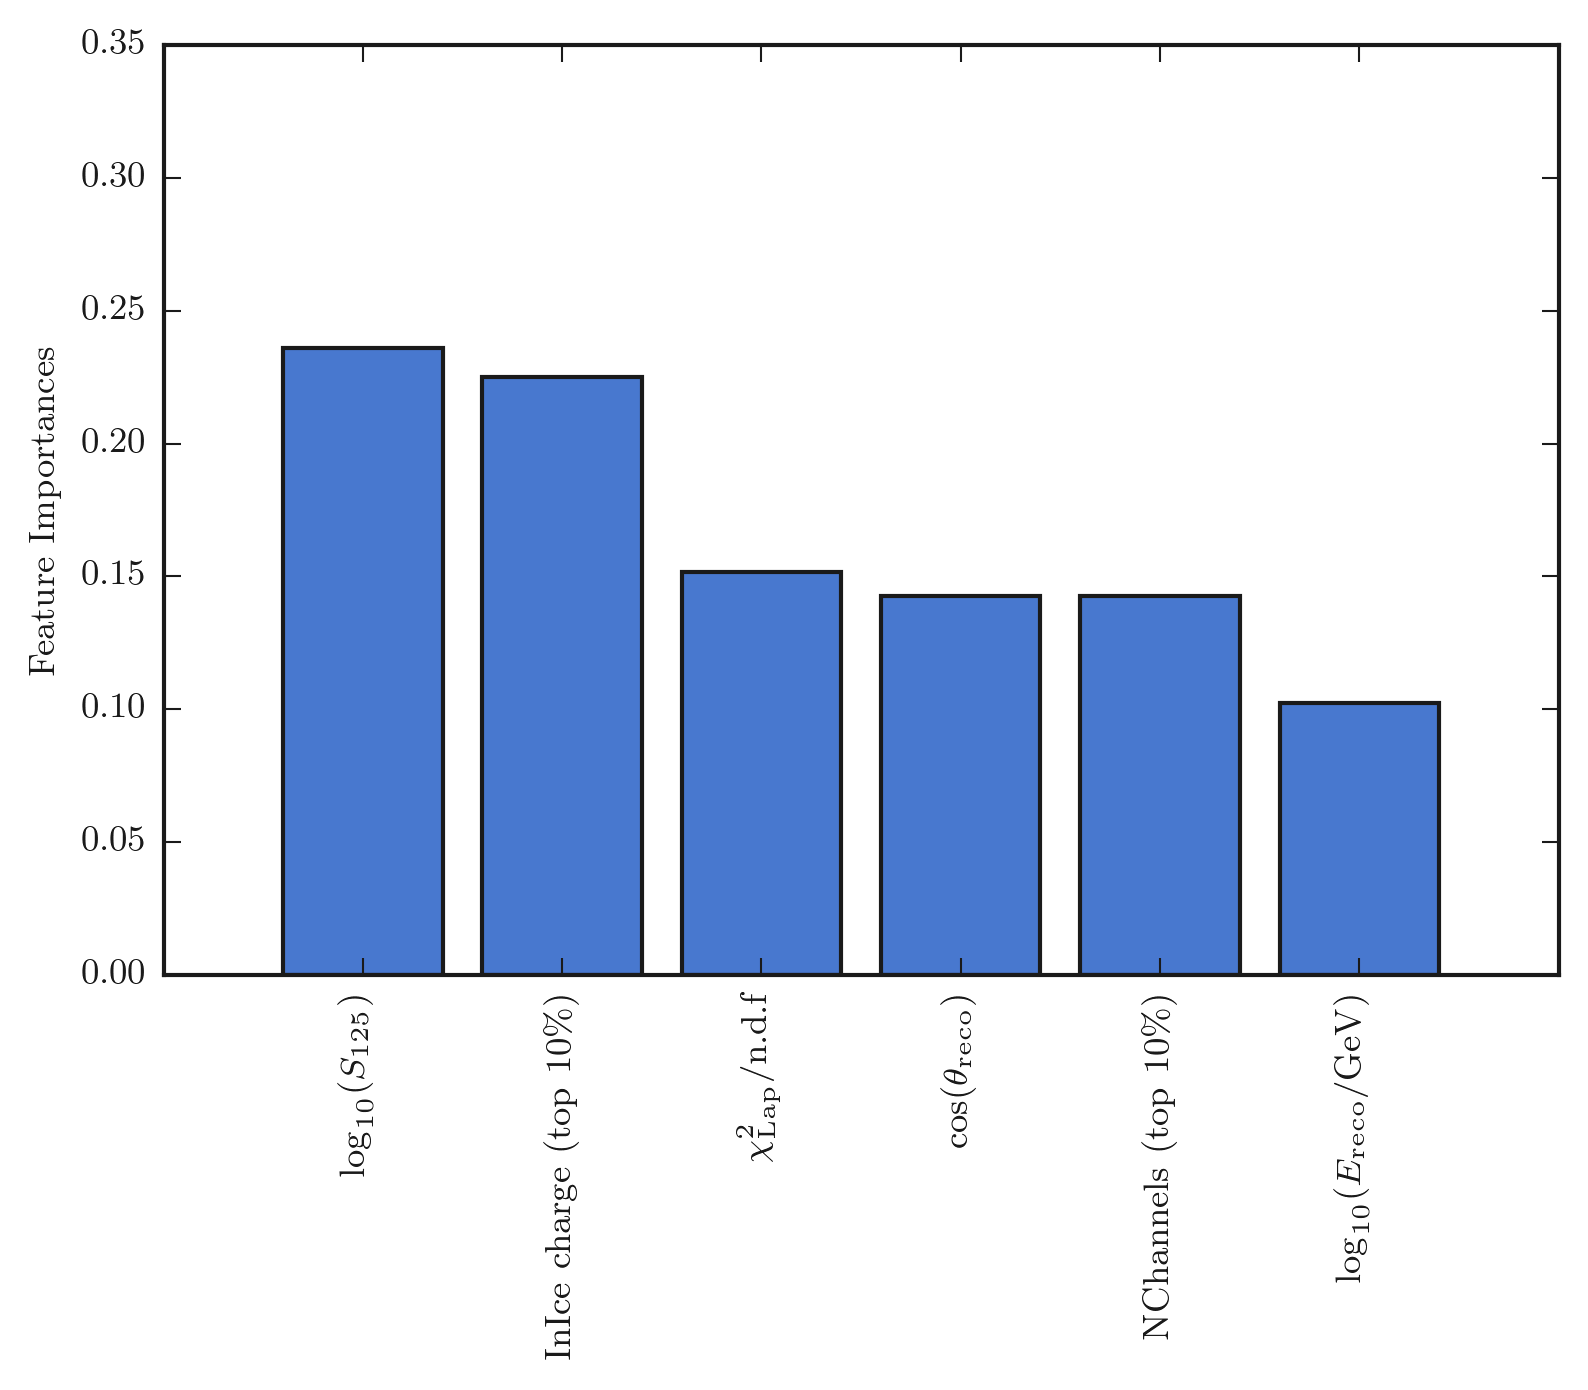

In [9]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.ylim([0, .35])
plt.show()